In [1]:
import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt

In [2]:
#Define algumas variáveis

pasta_datasets = '../datasets/'
pasta_planilha = '../planilhas/'
planilha = 'ipca_202103SerieHist.xls'

In [3]:
try:
    os.mkdir(pasta_datasets)
    print(f'"Pasta {pasta_datasets} criada') 
except FileExistsError:
    print(f'"Pasta {pasta_datasets} já existe') 

"Pasta ../datasets/ já existe


In [4]:
# Define os tipos dos dados de cada coluna de interesse
tipo_dados = {'ano': np.int64, 'mes': str, 'indice_dez93': np.float64, 'no_mes': np.float64, '3_meses': np.float64, 
              '6_meses': np.float64, 'no_ano': np.float64, '12_meses': np.float64}

# Carrega a planilha "Série Histórica IPCA" a partir da linha 9
df = pd.read_excel(pasta_planilha + planilha, skiprows=8, usecols="A:H", sheet_name=0, header=None,
                   names = tipo_dados.keys())

df

,ano,mes,indice_dez93,no_mes,3_meses,6_meses,no_ano,12_meses
0,1994,JAN,141.31,41.31,162.13,533.33,41.31,2693.84
1,NaN,FEV,198.22,40.27,171.24,568.17,98.22,3035.71
2,NaN,MAR,282.96,42.75,182.96,602.93,182.96,3417.39
3,NaN,ABR,403.73,42.68,185.71,648.92,303.73,3828.49
4,NaN,MAI,581.49,44.03,193.36,695.71,481.49,4331.19
...,...,...,...,...,...,...,...,...
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Há muitas linhas em branco em virtude da formatação da tabela
# Para limpar essas linhas indesejadas, vamos escolher os valores da coluna 'indice_dez93'

# Primeiro tentar converter para numérico, forçando um NaN onde for texto
df['indice_dez93'] = pd.to_numeric(df['indice_dez93'], errors = 'coerce')

# Todo mês deve ter um valor, então se tiver um NaN pode ser apagada a linha
df.dropna(subset = ['indice_dez93'], inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
# A coluna ano tem apenas o ano na primeira linha (janeiro), será necessário substituir os NaN
ano_inicial = 1994
contador = 0

for row in range(0, len(df)):
    df.loc[row, 'ano'] = ano_inicial
    contador += 1
    if contador == 12:
        ano_inicial += 1
        contador = 0

In [7]:
df['mes'].unique()

array(['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET',
       'OUT', 'NOV', 'DEZ'], dtype=object)

In [8]:
# A coluna mes precisa ser convertida para numérica
dict_mes = {'JAN': 1, 'FEV': 2, 'MAR': 3, 'ABR': 4, 'MAI': 5, 'JUN': 6, 
            'JUL': 7, 'AGO': 8, 'SET': 9, 'OUT': 10, 'NOV': 11, 'DEZ': 12}

df['mes'] = df['mes'].map(dict_mes)

In [9]:
#Cria uma coluna "data" a partir da combinação das colunas ano e mes
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str))

# Define a columa data como novo índice
df.set_index('data', inplace=True)

# Não são mais necessárias as colunas ano e mes
df.drop(columns=['ano','mes'], inplace=True)

# Como a arrecadação foi recuperada no período de 2004 a 2019, o IPCA deve estar disponível no mesmo período
df = df.loc['2004-01-01':'2019-12-01']

df

,indice_dez93,no_mes,3_meses,6_meses,no_ano,12_meses
data,,,,,,
2004-01-01,2246.43,0.76,1.63,3.07,0.76,7.71
2004-02-01,2260.13,0.61,1.9,3.34,1.37,6.69
2004-03-01,2270.75,0.47,1.85,3.03,1.85,5.89
2004-04-01,2279.15,0.37,1.46,3.11,2.23,5.26
2004-05-01,2290.77,0.51,1.36,3.28,2.75,5.15
...,...,...,...,...,...,...
2019-08-01,5229.93,0.11,0.31,1.77,2.54,3.43
2019-09-01,5227.84,-0.04,0.26,0.97,2.49,2.89
2019-10-01,5233.07,0.1,0.17,0.5,2.6,2.54


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2004-01-01 to 2019-12-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   indice_dez93  192 non-null    float64
 1   no_mes        192 non-null    object 
 2   3_meses       192 non-null    object 
 3   6_meses       192 non-null    object 
 4   no_ano        192 non-null    object 
 5   12_meses      192 non-null    object 
dtypes: float64(1), object(5)
memory usage: 10.5+ KB


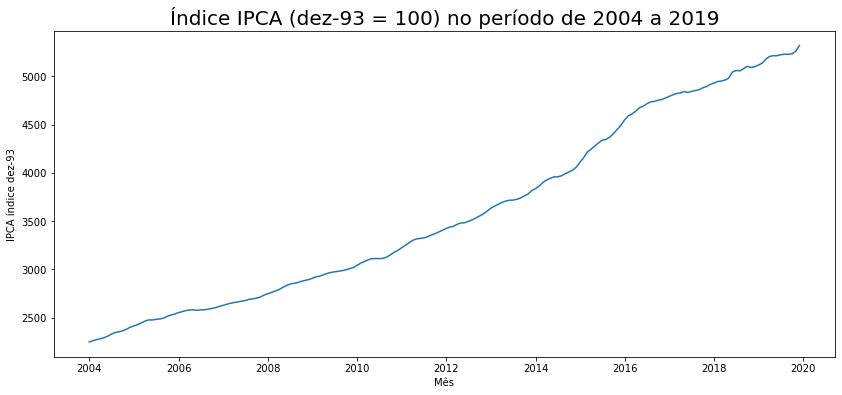

In [11]:
# Visualiza os dados do IPCA ao longo do tempo
fig, ax = plt.subplots(figsize=(14, 6))
plt.rcParams['font.size'] = '10'
plt.title('Índice IPCA (dez-93 = 100) no período de 2004 a 2019', fontdict={'size':20})
plt.ylabel('IPCA índice dez-93')
plt.xlabel('Mês')
plt.plot(df['indice_dez93'])
ax.ticklabel_format(style='plain',  axis='y')
plt.show();


In [12]:
# Exporta em padrão CSV e Excel
df.to_excel(pasta_planilha+'ipca.xlsx', index=True)
df.to_csv(pasta_datasets+'ipca.csv', index=True)